# Importing libraries

In [3]:
import numpy as np
import math as mt
import matplotlib.pyplot as plt
import astropy.io.fits as pf
from stingray.pulse import epoch_folding_search
from stingray.pulse import get_orbital_correction_from_ephemeris_file
import Important_Functions as IF
import scipy.stats as st
from importlib import reload

/opt/anaconda3/envs/testenv/lib/python3.10/site-packages/stingray/utils.py:25: UserWarning: pyfftw not installed. Using standard scipy fft
  warnings.warn("pyfftw not installed. Using standard scipy fft")
/opt/anaconda3/envs/testenv/lib/python3.10/site-packages/stingray/utils.py:40: UserWarning: Numba not installed. Faking it
  warnings.warn("Numba not installed. Faking it")


# Defining parameters 

In [24]:
#For retrieving data
filename = '/Users/samsonmercier/Desktop/UNIGE/ap-lab-i-2022/data/4u_1626/obs_lc'

#For orbital correction
#whether or not to perform orbital correction for source
use = False
#whether or not to perform orbital correction for background
use_bc = False

#For epoch_folding_search
#Distance from the periodogram best frequency to probe
dist = 3e-4
#number of frequencies to test between low_f and high_f
N = 1000
#length of segments in periodogram
seg_length = 20000


#Segmenting data energy-wise
#Number of segments
num_segments = -50
#Energy range of events to consider
E_min = 120
E_max = 2800


#Segmenting data time-wise
#Number of segments
num_time_segments = 50


#Making time pulse profile matrix 
#used for stingray lightcurve - detailed in module
dt = 0.01
#Confidence level for finding order of fit of each pulse profile
conf = 0.1
#Whether or not to plot the errors to each pulse profile
account_errs = False

#Title to use for the pulse profile matrix generated
title = 'Time Pulse Profile Matrix'

#Whether or not we want to save the pulse profile matrix to a pdf
save=False
#Path to where we save the pulse profile matrix pdf
save_path = '/Users/samsonmercier/Desktop/'


#Making energy pulse profile matrix
#used for stingray lightcurve - detailed in module
E_dt = 0.007
#Confidence level for finding order of fit of each pulse profile
E_conf = 0.1
#Whether or not to plot the errors to each pulse profile
E_account_errs = False
#Title to use for the pulse profile matrix generated
E_title = 'Energy Pulse Profile Matrix'
#The number of segments to use in the matrix - might not correspond
#to the total number of segments in which the data was cut
segs_to_use = 30
#Whether or not we want to save the pulse profile matrix to a pdf
E_save=True


#Making the RMS plot
#Setting the number of Poisson distribution realizations
#used in the bootstrap method
num_realizations = 1000


#Segmenting the background data energy-wise
#Number of segments
num_bc_segs = -50
#Energy range of events we consider
B_E_min = 120
B_E_max = 2800

# Analyzing source data

## Retrieve the data for two data sets

In [5]:
#Retrieving data for source file
Time_phase_file_A = pf.open(filename+'/sourceA.evt')
Time_phase_file_B = pf.open(filename+'/sourceB.evt')

#Getting event arrival time data
Time_phase_data_A=Time_phase_file_A[1].data
Time_phase_data_B=Time_phase_file_B[1].data


## Get GTIs for datasets

In [6]:
new_gti_A = IF.get_GTIs(Time_phase_file_A[2])
new_gti_B = IF.get_GTIs(Time_phase_file_B[2])

#The two GTI array have essentially the same values so we set 
new_gti = new_gti_A

## Orbitally correcting the arrival times

In [7]:
if use:
    correct_orbital_time_A = IF.get_orbital_correction(Time_phase_file_A[1], filename+'/orbit_t2.txt')
    correct_orbital_time_B = IF.get_orbital_correction(Time_phase_file_B[1], filename+'/orbit_t2.txt')


## Concatenating data for the two events and sorting them to maintain order

In [8]:
if use:
    correct_time = np.concatenate((correct_orbital_time_A, correct_orbital_time_B))
else:
    correct_time = np.concatenate((Time_phase_data_A['TIME'], Time_phase_data_B['TIME']))
    
total_energies = np.concatenate((Time_phase_data_A['PI'], Time_phase_data_B['PI']))

ind = np.argsort(correct_time)

total_correct_time = correct_time[ind]
total_correct_energies = total_energies[ind]

#Reference time used for the phase folding
ref_time = total_correct_time[0]

## Using the event arrival times with orbital correction and the Stingray function epoch_folding_search to find pulse frequency

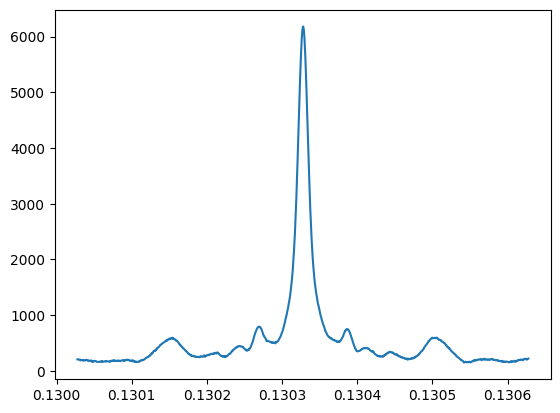

0.13032796880044265


In [9]:
reload(IF)
correct_list, guess_freq = IF.get_pulse_freq(N, total_correct_time, total_correct_energies, 
                                             dist, new_gti, seg_length)

#Plotting the power as a function energy
plt.plot(correct_list[0], correct_list[1])
plt.show()

#Printing the frequency with the highest power
#This value will later be used as the pulse frequency for our analysis
print(guess_freq)

#The pulse frequency obtained from epoch_folding search
pulse_freq = [guess_freq]


## Segmenting our data Energy-wise

In [11]:
reload(IF)

energy_time_segments, energy_segments = IF.segment_energywise(total_correct_time, 
                                                              total_correct_energies, E_min, E_max, num_segments)

## Segmenting our data Time-wise

In [12]:
reload(IF)

time_segs = IF.segment_timewise(total_correct_time, num_time_segments)

## Check the time pulse profile matrix to make sure the orbital correction was OK

9
6
5
5
6
5
5
5
6
6
5
10
5
6
5
5
5
5
6
6
7
6
6
5
6
6
5
6
5
5
5
5
6
5
5
5
5
5
5
6
9
5
5
5
6
6
7
9
5
5


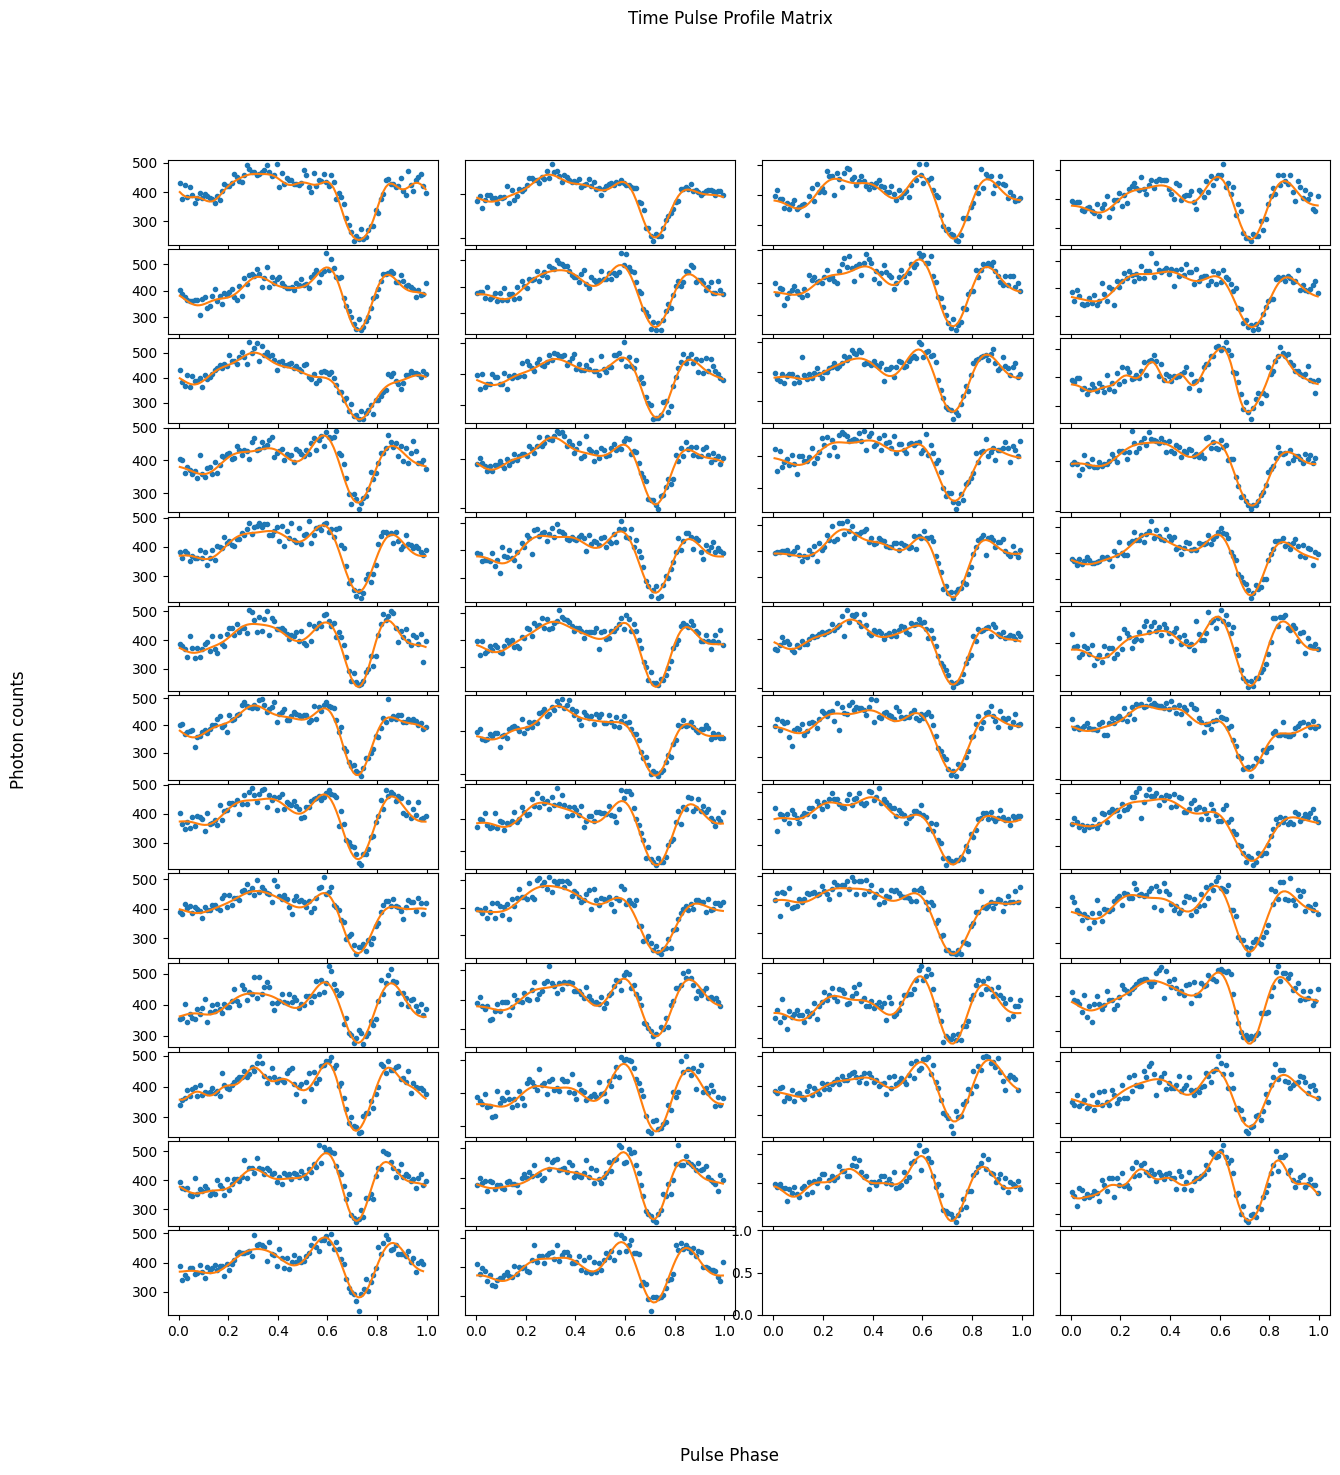

In [13]:
reload(IF)

orders, model_phases, counts, phasefold_time=IF.pulse_profile_matrix(time_segs, 
                                                                    ref_time, 
                                                                    pulse_freq, title, 
                                                                     num_time_segments, dt, conf, 
                                                                     account_errs, save)


## Make the energy pulse profile matrix 

5
5
6
6
5
5
5
5
4
5
4
4
4
3
8
3
7
3
5
6
5
4
10
4
3
2
4
10
2
10


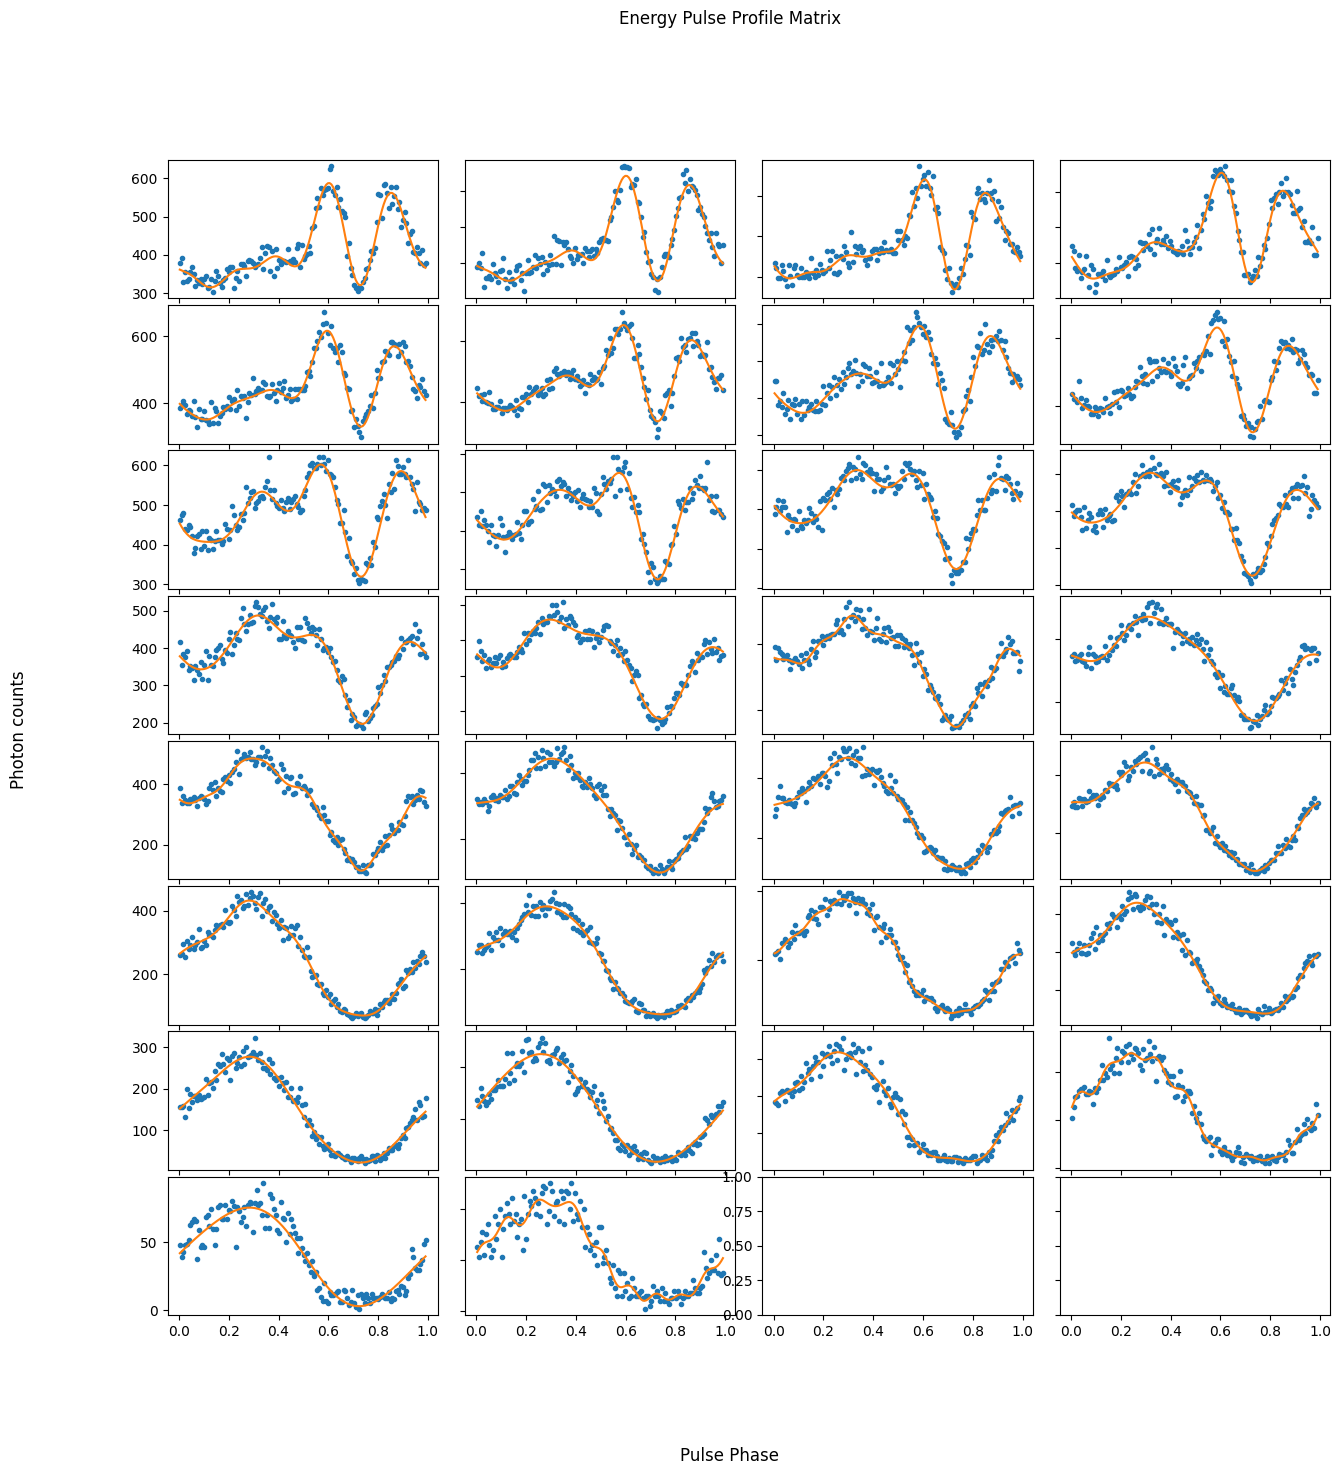

In [29]:
reload(IF)

energy_orders, energy_model_phases, energy_counts, energy_phasefold_time=IF.pulse_profile_matrix(energy_time_segments, ref_time, 
                                                            pulse_freq, E_title, segs_to_use, 
                                                             E_dt, E_conf, E_account_errs, E_save, save_path)


## Making the RMS vs Energy plot

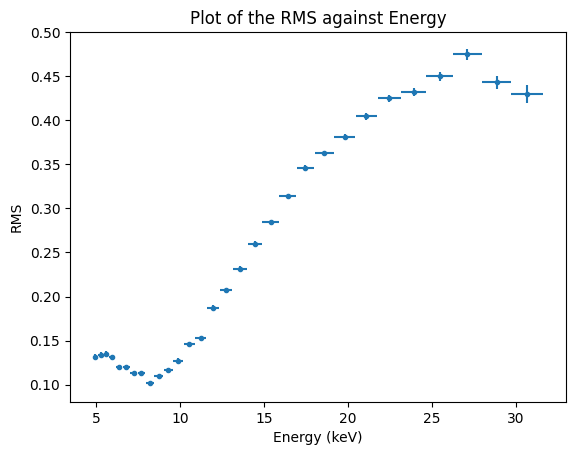

In [27]:
#Initializing:
#the RMS values for each segment
RMSs = np.zeros(len(energy_counts))
#the error on the RMS value for each segment - obtained from bootstrap method
RMS_error = np.ones(len(energy_counts))
#the average energy for each segment
avg = np.zeros(len(energy_counts))
#the error on the average energy of each segment 
E_rror = np.ones(len(energy_counts))

#Populating the arrays defined above, by iterating over the segments 
#output by the pulse profile function 
for i in range(len(energy_counts)):
    #Getting the error on the RMS values from the bootstrap method
    RMS_error[i] = IF.bootstrap_total(energy_counts[i], num_realizations, IF.RMS_calculator, energy_orders[i])
    #Getting the RMS from our RMS_calculator function
    RMSs[i] = IF.RMS_calculator(energy_counts[i], energy_orders[i])
    #Getting the average energy in each segment
    avg[i] = np.mean(energy_segments[i])
    #Getting the error on the average energy -> we don't use the bootstrap method for this
    E_rror[i] = 0.5*(max(energy_segments[i])-min(energy_segments[i]))
    
#Plotting the RMS against the average energy for each segment
fig, ax = plt.subplots(1, 1)
ax.errorbar(avg, RMSs, xerr=E_rror, yerr=RMS_error, fmt='.')
ax.set_xlabel('Energy (keV)')
ax.set_ylabel('RMS')
ax.set_title('Plot of the RMS against Energy')

plt.savefig('/Users/samsonmercier/Desktop/RMS_vs_Energy.pdf')

## Making the Time vs Phase plot

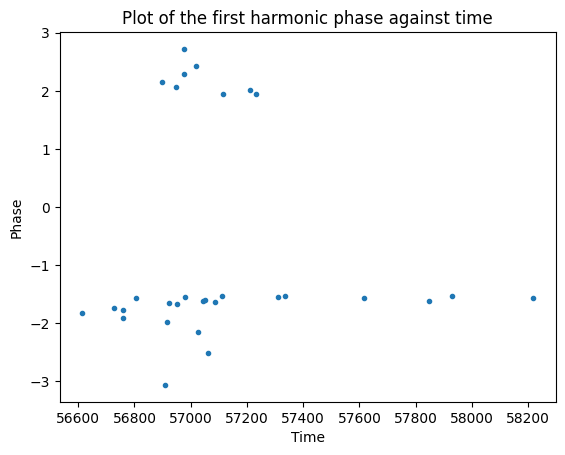

In [30]:
reload(IF)
IF.plot_time_vs_phase(energy_time_segments, energy_model_phases, E_save, save_path)

# Taking into account the background

## Importing the background data

In [ ]:
Time_phase_file_bc_A = pf.open(filename+'/backgroundA.evt')
Time_phase_file_bc_B = pf.open(filename+'/backgroundB.evt')

#Getting event arrival time data
Time_phase_data_bc_A=Time_phase_file_bc_A[1].data
Time_phase_data_bc_B=Time_phase_file_bc_B[1].data

## Orbitally correcting the event arrival times

In [ ]:
if use_bc:
    correct_orbital_time_bc_A = IF.get_orbital_correction(Time_phase_file_bc_A[1], filename+'/orbit_t2.txt')
    correct_orbital_time_bc_B = IF.get_orbital_correction(Time_phase_file_bc_B[1], filename+'/orbit_t2.txt')

## Get GTIs for datasets

In [ ]:
new_gti_bc_A = IF.get_GTIs(Time_phase_file_A[2])
new_gti_bc_B = IF.get_GTIs(Time_phase_file_B[2])

#The two GTI array have essentially the same values so we set 
new_gti_bc = new_gti_A

## Concatenating data for the two events and sorting them to maintain order

In [ ]:
if use_bc:
    correct_time_bc = np.concatenate((correct_orbital_time_bc_A, correct_orbital_time_bc_B))
else:
    correct_time_bc = np.concatenate((Time_phase_data_bc_A['TIME'], Time_phase_data_bc_B['TIME']))

total_energies_bc = np.concatenate((Time_phase_data_bc_A['PI'], Time_phase_data_bc_B['PI']))

ind2 = np.argsort(correct_time_bc)

total_correct_time_bc = correct_time_bc[ind2]
total_correct_energies_bc = total_energies_bc[ind2]


## Segmenting our data Energy-wise

In [ ]:

energy_time_segments_bc, energy_segments_bc = IF.segment_energywise(total_correct_time_bc, 
                                                              total_correct_energies_bc, B_E_min, 
                                                                    B_E_max, num_bc_segs)

# Plotting the RMS with and without the background

## Removing the background energy counts from the source energy counts for each segment

In [ ]:
#Initializing the list for energy counts with no background
nobc_energy_counts=[]

#Populating the source-background segments
for i in range(len(energy_counts)):
    #From the source energy counts, we remove the average background energy counts
    nobc_energy_counts.append(np.array(energy_counts[i])-len(energy_segments_bc[i])/np.abs(num_bc_segs))


In [ ]:
#Using the previously defined number of Poisson distribution realizations for the 
#bootstrap method

#Initializing:
#the RMS values for each segment
nobc_RMSs = np.zeros(len(energy_counts))
#the error on the RMS value for each segment - obtained from bootstrap method
nobc_RMS_error = np.ones(len(energy_counts))
#the average energy for each segment
nobc_avg = np.zeros(len(energy_counts))
#the error on the average energy of each segment 
nobc_E_rror = np.ones(len(energy_counts))


#Populating the arrays defined above, by iterating over the segments 
#output by the pulse profile function 
for i in range(len(energy_counts)):
    #Getting the error on the RMS values from the bootstrap method
    nobc_RMS_error[i] = IF.bootstrap_total(nobc_energy_counts[i], num_realizations, IF.RMS_calculator, energy_orders[i])
    #Getting the RMS from our RMS_calculator function  
    nobc_RMSs[i] = IF.RMS_calculator(nobc_energy_counts[i], energy_orders[i])
    #Getting the average energy in each segment
    nobc_avg[i] = np.mean(energy_segments[i])
    #Getting the error on the average energy -> we don't use the bootstrap method for this
    nobc_E_rror[i] = 0.5*(max(energy_segments[i])-min(energy_segments[i]))

#Plotting the RMS against the average energy for each segment, both for the 
#case where the background is present (blue) and the case where the background 
#was removed (red).
fig, ax = plt.subplots(1, 1)
ax.errorbar(nobc_avg, nobc_RMSs, xerr=nobc_E_rror, yerr=nobc_RMS_error, fmt='r.', label='Background Removed')
ax.errorbar(avg, RMSs, xerr=E_rror, yerr=RMS_error, fmt='b.', label='Background present')
ax.set_xlabel('Energy (keV)')
ax.set_ylabel('RMS')
ax.legend()
ax.set_title('Plot of the RMS against Energy for Bootstrap')

#plt.savefig('/Users/samsonmercier/Desktop/Comparative_RMS_vs_Energy.pdf')